In [28]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import torch.optim as optim
from torch.utils.data import Dataset
from datasets import load_dataset
import tqdm
from huggingface_hub import notebook_login
import matplotlib.pyplot as plt
from collections import Counter

# Dataset

## Download dataset

In [ ]:
dataset = load_dataset('conll2003')

In [140]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})


In [141]:
print(f"Tokens: {dataset['train']['tokens'][0]}")
print(f"tags: {dataset['train']['ner_tags'][0]}")

Tokens: ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
tags: [3, 0, 7, 0, 0, 0, 7, 0, 0]


## Build Vocab

In [166]:
all_tokens = [token for example in dataset['train'] for token in example['tokens']]
vocab_counter = Counter(all_tokens)
vocab = {'<PAD>': 0, '<UNK>': 1}
vocab.update({token: idx + 2 for idx, (token, _) in enumerate(vocab_counter.items())})

In [167]:
vocab_size = len(vocab)
vocab_size

23625

In [169]:
tags = dataset['train'].features['ner_tags'].feature.names
print(f"tags : {tags}")

tags : ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']


In [170]:
n_tags = len(tags)
print(n_tags)

9


In [171]:
idx2label = {idx:label for idx, label in enumerate(tags)}
idx2label

{0: 'O',
 1: 'B-PER',
 2: 'I-PER',
 3: 'B-ORG',
 4: 'I-ORG',
 5: 'B-LOC',
 6: 'I-LOC',
 7: 'B-MISC',
 8: 'I-MISC'}

## Map to ids

In [ ]:
def tokens_to_ids(example):
    example['input_ids'] = [vocab.get(token, vocab['<UNK>']) for token in example['tokens']]
    return example

dataset = dataset.map(tokens_to_ids)

In [ ]:
dataset = dataset.map(lambda x: {'len': len(x['tokens'])})

## Dataset class

In [174]:
class NERDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, idx):
        data = self.dataset[idx]
        return torch.tensor(data['input_ids']), torch.tensor(data['ner_tags']), torch.tensor(data['len'])
        

In [175]:
label_pad_idx = -100

In [176]:
def collate_fn(batch):
    input_ids, labels, lengths_list = zip(*batch)

    lengths = torch.tensor(lengths_list)
    
    lengths, idx = lengths.sort(descending=True)
    input_ids = [input_ids[i] for i in idx]
    labels = [labels[i] for i in idx]

    padded_inputs = pad_sequence(input_ids, batch_first=True, padding_value=vocab['<PAD>'])
    padded_labels = pad_sequence(labels, batch_first=True, padding_value=label_pad_idx)  

    return padded_inputs, padded_labels, lengths

## Datasets

In [177]:
train_dataset = NERDataset(dataset['train'])
val_dataset = NERDataset(dataset['validation'])
test_dataset = NERDataset(dataset['test'])

## Dataloaders

In [178]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, num_workers=2, shuffle=True, collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

# Model Class

In [179]:
class NERTagger(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            bidirectional=bidirectional,
            dropout=dropout if n_layers > 1 else 0,
            batch_first=True
        )
        lstm_output_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.fc = nn.Linear(lstm_output_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text, lengths):
        embedded = self.embedding(text)
        packed_embedded = pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=True)
        packed_output, _ = self.lstm(packed_embedded)
        lstm_out, _ = pad_packed_sequence(packed_output, batch_first=True)

        lstm_out = self.dropout(lstm_out)
        logits = self.fc(lstm_out) 
        
        return logits

# Training Loop

In [185]:
def training_loop(model, train_loader, optimizer, criterion, epochs, device, label_pad_idx):
    model.train()
    losses = []
    accuracies = []

    for epoch in range(epochs):
        running_loss = 0.0
        total_correct = 0
        total_tokens = 0

        progress_bar = tqdm.tqdm(train_loader, desc=f"Epoch {epoch + 1} / {epochs}")
        for inputs, labels, lengths in progress_bar:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs, lengths)

            loss = criterion(outputs.view(-1, outputs.shape[-1]), labels.view(-1))
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * labels.size(0)

            preds = torch.argmax(outputs, dim=2)  
            mask = labels != label_pad_idx
            total_correct += ((preds == labels) & mask).sum().item()
            total_tokens += mask.sum().item()

            avg_batch_loss = running_loss / total_tokens
            batch_accuracy = total_correct / total_tokens
            progress_bar.set_postfix(loss=f"{avg_batch_loss:.4f}", accuracy=f"{batch_accuracy:.4f}")

        epoch_loss = running_loss / total_tokens
        epoch_accuracy = total_correct / total_tokens
        losses.append(epoch_loss)
        accuracies.append(epoch_accuracy)

    return losses, accuracies

In [209]:
embedding_dim = 500
hidden_dim = 256
pad_idx = vocab['<PAD>']
output_dim = n_tags

## Model 1

- uni direction
- 1 layer

In [210]:
n_layers = 1
bidirectional = False
dropout = 0.5

In [211]:
model = NERTagger(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=label_pad_idx)
epochs = 10

In [ ]:
losses_1, accuracies_1 = training_loop(model,
                                   train_loader,
                                   optimizer,
                                   criterion,
                                   epochs,
                                   device,
                                   label_pad_idx)

## Model 2

- bi-directional
- 1 layer

In [215]:
n_layers = 1
bidirectional = True
dropout = 0.5

In [216]:
model_2 = NERTagger(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_2 = model_2.to(device)
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=label_pad_idx)
epochs = 10

In [ ]:
losses_2, accuracies_2 = training_loop(model_2,
                                   train_loader,
                                   optimizer,
                                   criterion,
                                   epochs,
                                   device,
                                   label_pad_idx)

## Model 3

- uni direction
- 2 layer

In [218]:
n_layers = 2
bidirectional = False
dropout = 0.5

In [219]:
model_3 = NERTagger(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_2 = model_3.to(device)
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=label_pad_idx)
epochs = 10

In [ ]:
losses_3, accuracies_3 = training_loop(model_3,
                                   train_loader,
                                   optimizer,
                                   criterion,
                                   epochs,
                                   device,
                                   label_pad_idx)

## Model 4

- bi-direction
- 2 layer

In [221]:
n_layers = 2
bidirectional = True
dropout = 0.5

In [222]:
model_4 = NERTagger(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_2 = model_4.to(device)
optimizer = torch.optim.Adam(model_4.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=label_pad_idx)
epochs = 10

In [ ]:
losses_4, accuracies_4 = training_loop(model_4,
                                   train_loader,
                                   optimizer,
                                   criterion,
                                   epochs,
                                   device,
                                   label_pad_idx)

# Results

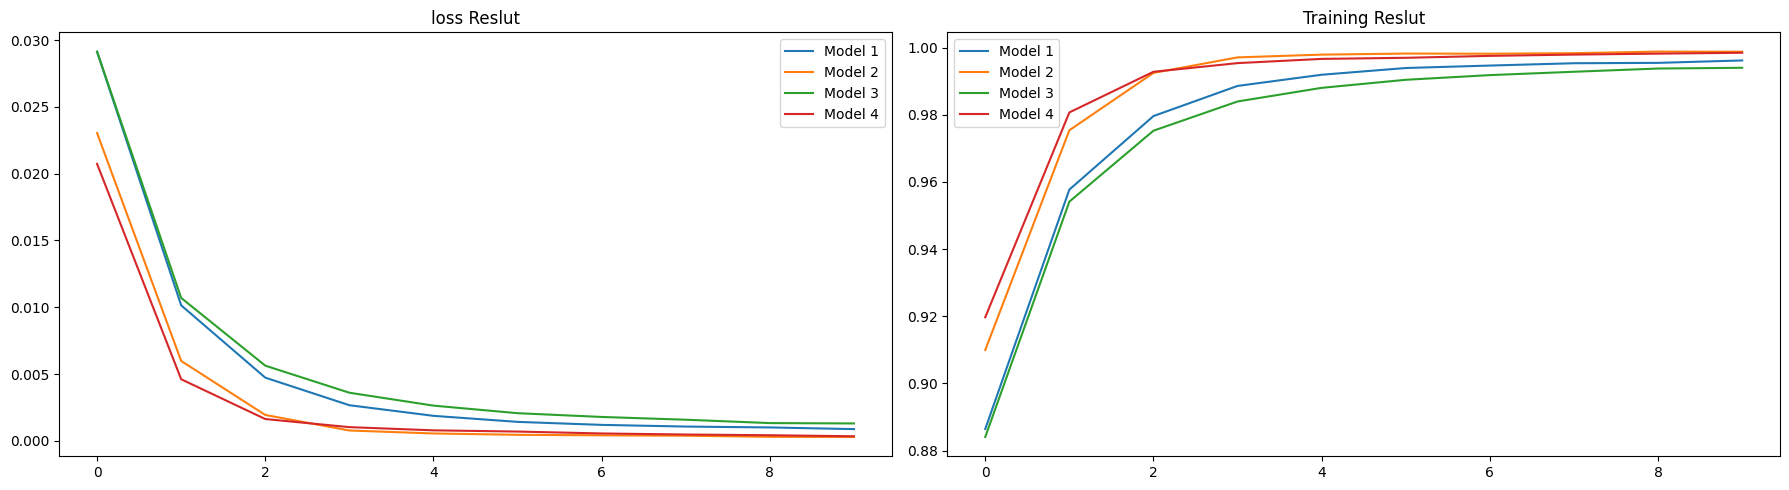

In [224]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))
ax[0].plot(losses_1)
ax[0].plot(losses_2)
ax[0].plot(losses_3)
ax[0].plot(losses_4)
ax[0].set_title("loss Reslut")
ax[0].legend(['Model 1', 'Model 2', 'Model 3', 'Model 4'])

ax[1].plot(accuracies_1)
ax[1].plot(accuracies_2)
ax[1].plot(accuracies_3)
ax[1].plot(accuracies_4)
ax[1].set_title("Training Reslut")
ax[1].legend(['Model 1', 'Model 2', 'Model 3', 'Model 4'])

plt.tight_layout()
plt.show()

# Inferance

In [225]:
def inference_loop(model, data_loader, device, idx_to_label=None, max_examples=20):
    model.eval()
    examples_shown = 0
    total_correct = 0
    total_tokens = 0

    with torch.inference_mode():
        for inputs, labels, lengths in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs, lengths)

            preds = torch.argmax(outputs, dim=2)  
            mask = labels != label_pad_idx
            total_correct += ((preds == labels) & mask).sum().item()
            total_tokens += mask.sum().item()

      
            if examples_shown < max_examples:
                for i in range(len(labels)):
                    pred_label = preds[i]
                    true_label = labels[i]
                    
                    print(f"[Example {examples_shown + 1}]")
                    print(f"Prediction: {[idx_to_label[label.item()] for label in pred_label if label != -100] }")
                    print(f"Ground Truth: {[idx_to_label[label.item()] for label in true_label if label != -100]}")
                    print("-" * 40)
                    examples_shown += 1
                    if examples_shown >= max_examples:
                        break

    accuracy = total_correct / total_tokens if total_tokens > 0 else 0
    print(f" Inference Accuracy: {accuracy * 100:.2f}%")

    return accuracy

In [226]:
accuracy = inference_loop(model_4, test_loader, device, idx_to_label=idx2label, max_examples=10)

[Example 1]
Prediction: ['B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Ground Truth: ['B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------
[Example 2]
Prediction: ['B-LOC', 'I-LOC', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'O', 'B-ORG', 'I-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Ground Truth: ['B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O'

In [227]:
accuracy = inference_loop(model_3, test_loader, device, idx_to_label=idx2label, max_examples=10)

[Example 1]
Prediction: ['B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Ground Truth: ['B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------
[Example 2]
Prediction: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Ground Truth: ['B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',

In [228]:
accuracy = inference_loop(model_2, test_loader, device, idx_to_label=idx2label, max_examples=10)

[Example 1]
Prediction: ['B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Ground Truth: ['B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------
[Example 2]
Prediction: ['B-LOC', 'I-LOC', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'O', 'B-ORG', 'I-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Ground Truth: ['B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O'

In [229]:
accuracy = inference_loop(model, test_loader, device, idx_to_label=idx2label, max_examples=10)

[Example 1]
Prediction: ['B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Ground Truth: ['B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------
[Example 2]
Prediction: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'B-ORG', 'B-ORG', 'B-ORG']
Ground Truth: ['B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O'